# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "abomination-vaults-bestiary.db",
    "age-of-ashes-bestiary.db",
    "agents-of-edgewatch-bestiary.db",
    "april-fools-bestiary.db",
    "blog-bestiary.db",
    "blood-lords-bestiary.db",
    "book-of-the-dead-bestiary.db",
    "crown-of-the-kobold-king-bestiary.db",
    "extinction-curse-bestiary.db",
    "fall-of-plaguestone.db",
    "fists-of-the-ruby-phoenix-bestiary.db",
    "gatewalkers-bestiary.db",
    "impossible-lands-bestiary.db",
    "kingmaker-bestiary.db",
    "malevolence-bestiary.db",
    "menace-under-otari-bestiary.db",
    "monsters-of-myth-bestiary.db",
    "mwangi-expanse-bestiary.db",
    "night-of-the-gray-death-bestiary.db",
    "npc-gallery.db",
    "one-shot-bestiary.db",
    "outlaws-of-alkenstar-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
    "pathfinder-bestiary.db",
    "pathfinder-dark-archive.db",
    "pfs-introductions-bestiary.db",
    "pfs-season-1-bestiary.db",
    "pfs-season-2-bestiary.db",
    "pfs-season-3-bestiary.db",
    "pfs-season-4-bestiary.db",
    "quest-for-the-frozen-flame-bestiary.db",
    "shadows-at-sundown-bestiary.db",
    "strength-of-thousands-bestiary.db",
    "the-slithering-bestiary.db",
    "travel-guide-bestiary.db",
    "troubles-in-otari-bestiary.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 4327
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   con     3690 non-null   float64
 1   ac      3690 non-null   float64
 2   int     3690 non-null   float64
 3   dex     3690 non-null   float64
 4   level   3690 non-null   int64  
 5   book    3690 non-null   object 
 6   hp      3690 non-null   int32  
 7   cha     3690 non-null   float64
 8   wis     3690 non-null   float64
 9   str     3690 non-null   float64
dtypes: float64(7), int32(1), int64(1), object(1)
memory usage: 302.7+ KB


In [3]:
df.head()

,con,ac,int,dex,level,book,hp,cha,wis,str
0,0.0,28.0,0.0,3.0,9,Pathfinder #165: Eyes of Empty Death,155,0.0,3.0,6.0
1,6.0,30.0,0.0,3.0,10,Pathfinder Abomination Vaults Hardcover Compil...,175,0.0,3.0,7.0
2,1.0,17.0,-2.0,3.0,2,Pathfinder #164: Hands of the Devil,38,1.0,3.0,4.0
3,3.0,27.0,0.0,4.0,8,Pathfinder #164: Hands of the Devil,140,1.0,3.0,3.0
4,0.0,31.0,2.0,6.0,9,Pathfinder #165: Eyes of Empty Death,90,2.0,4.0,-5.0


###### Level

In [4]:
y = df["level"]
y

0        9
1       10
2        2
3        8
4        9
        ..
4322     2
4324     3
4325     4
4326     2
4327     2
Name: level, Length: 3690, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,147
1,0,87
2,1,320
3,2,335
4,3,339
5,4,274
6,5,268
7,6,220
8,7,215
9,8,188


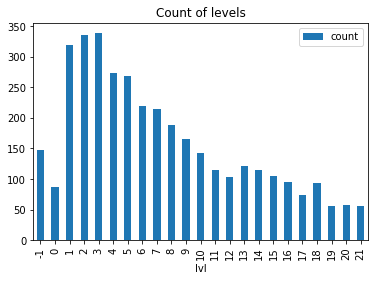

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 1626, number of used features: 8
[LightGBM] [Info] Start training from score 7.212177
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.575509	valid_0's l1: 0.447897


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.76
MAE: 0.45


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.31
RMSE test: 0.76


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

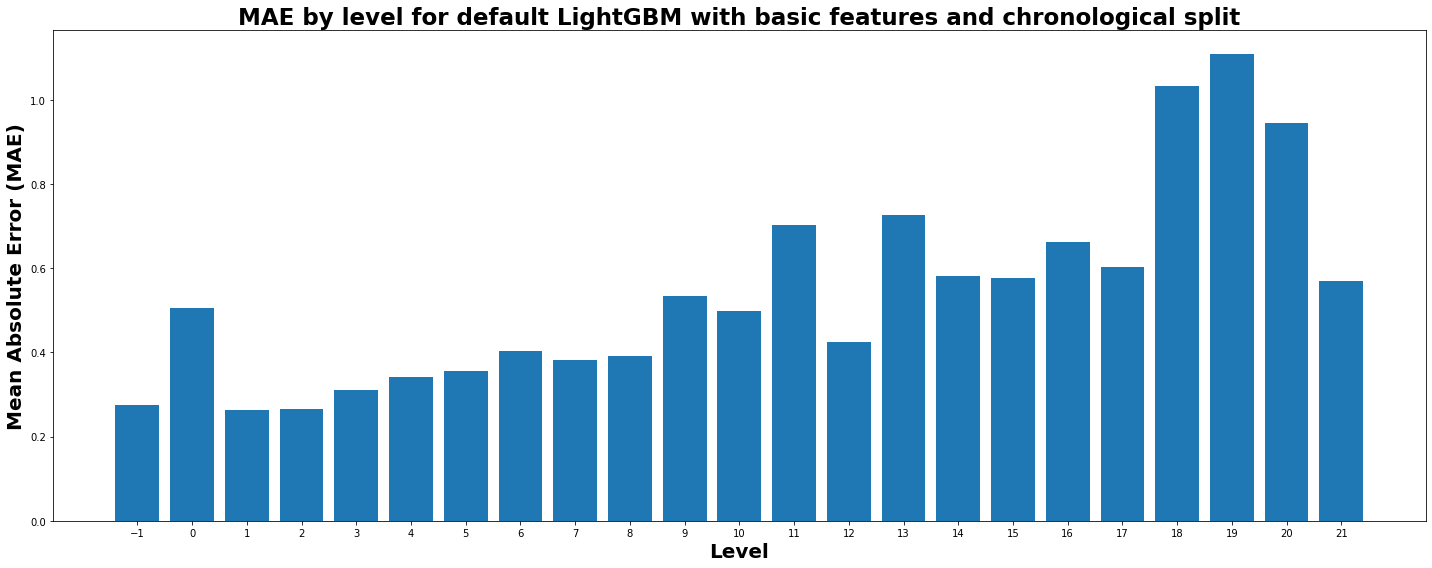

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and chronological split",
)

In [19]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.76

Round type: 0.5
RMSE: 0.78

Round type: 0.33
RMSE: 0.77

Round type: 0.45
RMSE: 0.77



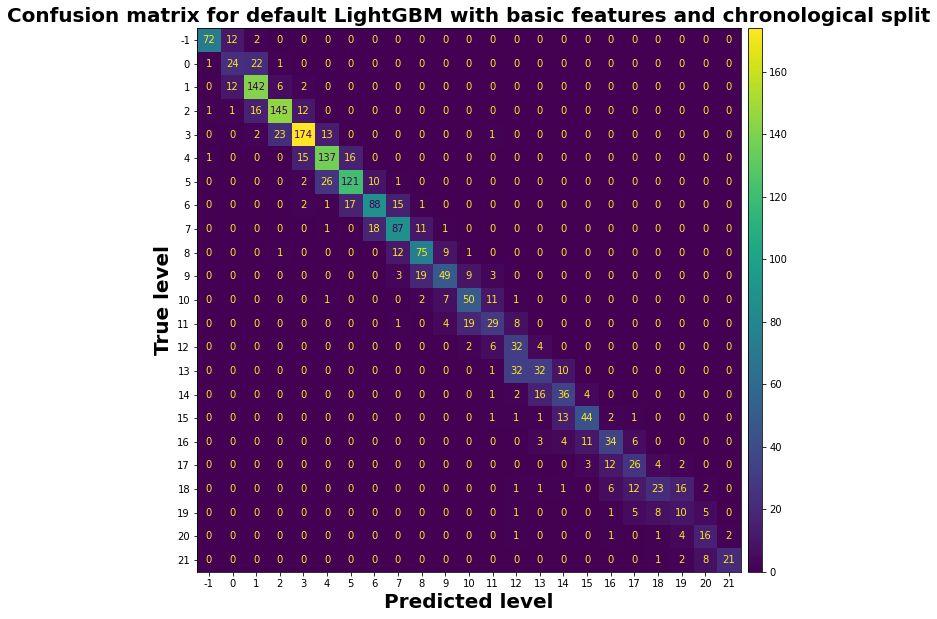

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with basic features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-12-01 17:40:24,356] A new study created in memory with name: no-name-327b1823-7711-4fad-82d6-5747ad96b38a
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.284776 + 0.144934


feature_fraction, val_score: 0.283812:  14%|######4                                      | 1/7 [00:01<00:07,  1.24s/it]

[200]	cv_agg's l2: 0.289839 + 0.142094
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901
[100]	cv_agg's l2: 0.302825 + 0.16381


feature_fraction, val_score: 0.283812:  29%|############8                                | 2/7 [00:02<00:05,  1.12s/it]

[200]	cv_agg's l2: 0.303966 + 0.157482
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901
[100]	cv_agg's l2: 0.481086 + 0.333496


feature_fraction, val_score: 0.283812:  43%|###################2                         | 3/7 [00:03<00:04,  1.08s/it]

[200]	cv_agg's l2: 0.428473 + 0.276261
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901
[100]	cv_agg's l2: 0.369292 + 0.208526


feature_fraction, val_score: 0.283812:  57%|#########################7                   | 4/7 [00:04<00:03,  1.29s/it][I 2023-12-01 17:40:29,280] Trial 3 finished with value: 0.36242853474033937 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.2838124480768287.


[200]	cv_agg's l2: 0.354437 + 0.188102
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901


feature_fraction, val_score: 0.283812:  57%|#########################7                   | 4/7 [00:04<00:03,  1.29s/it]

[100]	cv_agg's l2: 0.319985 + 0.181068


feature_fraction, val_score: 0.283812:  71%|################################1            | 5/7 [00:06<00:03,  1.52s/it]

[200]	cv_agg's l2: 0.317361 + 0.168309
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901


[I 2023-12-01 17:40:31,218] Trial 4 finished with value: 0.3159438587894553 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.2838124480768287.
feature_fraction, val_score: 0.283812:  71%|################################1            | 5/7 [00:06<00:03,  1.52s/it]

[100]	cv_agg's l2: 0.2902 + 0.141111


feature_fraction, val_score: 0.283812:  71%|################################1            | 5/7 [00:08<00:03,  1.52s/it]

[200]	cv_agg's l2: 0.296659 + 0.138289
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901


feature_fraction, val_score: 0.283812:  86%|######################################5      | 6/7 [00:08<00:01,  1.65s/it]

[100]	cv_agg's l2: 0.302825 + 0.16381
[200]	cv_agg's l2: 0.303966 + 0.157482


feature_fraction, val_score: 0.283812: 100%|#############################################| 7/7 [00:10<00:00,  1.54s/it]


Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901


num_leaves, val_score: 0.283812:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.28925 + 0.139554
[200]	cv_agg's l2: 0.299919 + 0.139407


num_leaves, val_score: 0.283812:   5%|##5                                               | 1/20 [00:02<00:55,  2.95s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901
[100]	cv_agg's l2: 0.28925 + 0.139554
[200]	cv_agg's l2: 0.299919 + 0.139407


num_leaves, val_score: 0.283812:  10%|#####                                             | 2/20 [00:05<00:50,  2.83s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901
[100]	cv_agg's l2: 0.28925 + 0.139554
[200]	cv_agg's l2: 0.299919 + 0.139407


num_leaves, val_score: 0.283812:  15%|#######5                                          | 3/20 [00:08<00:50,  2.97s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.283812 + 0.142901
[100]	cv_agg's l2: 0.275648 + 0.135562


num_leaves, val_score: 0.274577:  20%|##########                                        | 4/20 [00:10<00:36,  2.27s/it]

[200]	cv_agg's l2: 0.278062 + 0.13329
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.276084 + 0.134066


num_leaves, val_score: 0.274577:  25%|############5                                     | 5/20 [00:11<00:28,  1.92s/it]

[200]	cv_agg's l2: 0.280976 + 0.131765
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.293717 + 0.130628


num_leaves, val_score: 0.274577:  30%|###############                                   | 6/20 [00:11<00:20,  1.48s/it]

[200]	cv_agg's l2: 0.283701 + 0.13013
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.293717 + 0.130628


num_leaves, val_score: 0.274577:  35%|#################5                                | 7/20 [00:12<00:16,  1.26s/it]

[200]	cv_agg's l2: 0.283701 + 0.13013
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28925 + 0.139554


num_leaves, val_score: 0.274577:  40%|####################                              | 8/20 [00:15<00:20,  1.70s/it]

[200]	cv_agg's l2: 0.299919 + 0.139407
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28925 + 0.139554


num_leaves, val_score: 0.274577:  45%|######################5                           | 9/20 [00:18<00:22,  2.02s/it]

[200]	cv_agg's l2: 0.299919 + 0.139407
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28925 + 0.139554


num_leaves, val_score: 0.274577:  50%|########################5                        | 10/20 [00:20<00:21,  2.18s/it]

[200]	cv_agg's l2: 0.299919 + 0.139407
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.285105 + 0.141362


num_leaves, val_score: 0.274577:  55%|##########################9                      | 11/20 [00:22<00:19,  2.18s/it]

[200]	cv_agg's l2: 0.29222 + 0.14105
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28925 + 0.139554


num_leaves, val_score: 0.274577:  60%|#############################4                   | 12/20 [00:25<00:18,  2.30s/it]

[200]	cv_agg's l2: 0.299919 + 0.139407
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28925 + 0.139554


num_leaves, val_score: 0.274577:  65%|###############################8                 | 13/20 [00:28<00:17,  2.43s/it]

[200]	cv_agg's l2: 0.299919 + 0.139407
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28785 + 0.148096
[200]	cv_agg's l2: 0.293478 + 0.147127


num_leaves, val_score: 0.274577:  70%|##################################3              | 14/20 [00:30<00:14,  2.42s/it]

Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28925 + 0.139554


num_leaves, val_score: 0.274577:  75%|####################################7            | 15/20 [00:33<00:12,  2.51s/it]

[200]	cv_agg's l2: 0.299919 + 0.139407
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28925 + 0.139554


num_leaves, val_score: 0.274577:  80%|#######################################2         | 16/20 [00:36<00:10,  2.64s/it]

[200]	cv_agg's l2: 0.299919 + 0.139407
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.28925 + 0.139554


num_leaves, val_score: 0.274577:  85%|#########################################6       | 17/20 [00:39<00:08,  2.77s/it]

[200]	cv_agg's l2: 0.299919 + 0.139407
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185


num_leaves, val_score: 0.274577:  90%|############################################1    | 18/20 [00:39<00:04,  2.03s/it]

[100]	cv_agg's l2: 0.40295 + 0.168146
[200]	cv_agg's l2: 0.365279 + 0.157865
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.286325 + 0.1416


num_leaves, val_score: 0.274577:  95%|##############################################5  | 19/20 [00:42<00:02,  2.28s/it]

[200]	cv_agg's l2: 0.294571 + 0.141887
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.284427 + 0.140364


num_leaves, val_score: 0.274577: 100%|#################################################| 20/20 [00:44<00:00,  2.22s/it]


[200]	cv_agg's l2: 0.292757 + 0.140603
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185


bagging, val_score: 0.274577:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.288587 + 0.135642


bagging, val_score: 0.274577:  10%|#####3                                               | 1/10 [00:01<00:10,  1.18s/it]

[200]	cv_agg's l2: 0.283653 + 0.129096
Early stopping, best iteration is:
[112]	cv_agg's l2: 0.274577 + 0.135185
[100]	cv_agg's l2: 0.27711 + 0.136522
[200]	cv_agg's l2: 0.276344 + 0.136341


bagging, val_score: 0.274130:  20%|##########6                                          | 2/10 [00:02<00:10,  1.27s/it]

Early stopping, best iteration is:
[151]	cv_agg's l2: 0.27413 + 0.136969
[100]	cv_agg's l2: 0.272704 + 0.135543


bagging, val_score: 0.270198:  30%|###############9                                     | 3/10 [00:03<00:08,  1.23s/it]

[200]	cv_agg's l2: 0.27414 + 0.133936
Early stopping, best iteration is:
[121]	cv_agg's l2: 0.270198 + 0.134445
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


bagging, val_score: 0.269646:  40%|#####################2                               | 4/10 [00:05<00:07,  1.27s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.275462 + 0.13857
[200]	cv_agg's l2: 0.277855 + 0.138774


bagging, val_score: 0.269646:  50%|##########################5                          | 5/10 [00:06<00:06,  1.30s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.277517 + 0.13199
[200]	cv_agg's l2: 0.278531 + 0.13139


bagging, val_score: 0.269646:  60%|###############################8                     | 6/10 [00:07<00:05,  1.33s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.270925 + 0.13643
[200]	cv_agg's l2: 0.274035 + 0.135584


bagging, val_score: 0.269646:  70%|#####################################                | 7/10 [00:09<00:03,  1.31s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.275621 + 0.139032
[200]	cv_agg's l2: 0.278703 + 0.135688


bagging, val_score: 0.269646:  80%|##########################################4          | 8/10 [00:10<00:02,  1.37s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.274864 + 0.134505
[200]	cv_agg's l2: 0.276012 + 0.13473


bagging, val_score: 0.269646:  90%|###############################################7     | 9/10 [00:11<00:01,  1.39s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.283256 + 0.140785
[200]	cv_agg's l2: 0.282573 + 0.135146


bagging, val_score: 0.269646: 100%|####################################################| 10/10 [00:13<00:00,  1.33s/it]


Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898


feature_fraction_stage2, val_score: 0.269646:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


feature_fraction_stage2, val_score: 0.269646:  17%|######3                               | 1/6 [00:01<00:06,  1.31s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.275141 + 0.129057
[200]	cv_agg's l2: 0.278808 + 0.1293


feature_fraction_stage2, val_score: 0.269646:  33%|############6                         | 2/6 [00:02<00:05,  1.48s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


feature_fraction_stage2, val_score: 0.269646:  50%|###################                   | 3/6 [00:04<00:04,  1.42s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.275141 + 0.129057
[200]	cv_agg's l2: 0.278808 + 0.1293


feature_fraction_stage2, val_score: 0.269646:  67%|#########################3            | 4/6 [00:05<00:02,  1.37s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


feature_fraction_stage2, val_score: 0.269646:  83%|###############################6      | 5/6 [00:06<00:01,  1.34s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


feature_fraction_stage2, val_score: 0.269646: 100%|######################################| 6/6 [00:08<00:00,  1.37s/it]


Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898


regularization_factors, val_score: 0.269646:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.272634 + 0.13352
[200]	cv_agg's l2: 0.272621 + 0.129174


regularization_factors, val_score: 0.269646:   5%|#9                                    | 1/20 [00:01<00:25,  1.34s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  10%|###8                                  | 2/20 [00:02<00:24,  1.33s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.304789 + 0.13243


regularization_factors, val_score: 0.269646:  15%|#####7                                | 3/20 [00:03<00:21,  1.29s/it]

[200]	cv_agg's l2: 0.298681 + 0.130603
Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  20%|#######6                              | 4/20 [00:05<00:21,  1.34s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  25%|#########5                            | 5/20 [00:06<00:20,  1.39s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  30%|###########4                          | 6/20 [00:08<00:21,  1.53s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  35%|#############3                        | 7/20 [00:09<00:18,  1.46s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  40%|###############2                      | 8/20 [00:11<00:17,  1.43s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  45%|#################1                    | 9/20 [00:12<00:15,  1.38s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  50%|##################5                  | 10/20 [00:13<00:13,  1.35s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  55%|####################3                | 11/20 [00:15<00:12,  1.37s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  60%|######################2              | 12/20 [00:16<00:11,  1.38s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  65%|########################             | 13/20 [00:18<00:09,  1.37s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  70%|#########################9           | 14/20 [00:19<00:08,  1.40s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  75%|###########################7         | 15/20 [00:20<00:06,  1.39s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272975 + 0.12891


regularization_factors, val_score: 0.269646:  80%|#############################6       | 16/20 [00:22<00:05,  1.37s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.272185 + 0.132686
[200]	cv_agg's l2: 0.272708 + 0.131885


regularization_factors, val_score: 0.269646:  85%|###############################4     | 17/20 [00:23<00:04,  1.35s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.2723 + 0.132588
[200]	cv_agg's l2: 0.273432 + 0.131329


regularization_factors, val_score: 0.269646:  90%|#################################3   | 18/20 [00:25<00:02,  1.44s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646:  95%|###################################1 | 19/20 [00:26<00:01,  1.44s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.271508 + 0.130804
[200]	cv_agg's l2: 0.272976 + 0.12891


regularization_factors, val_score: 0.269646: 100%|#####################################| 20/20 [00:27<00:00,  1.40s/it]


Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898


min_data_in_leaf, val_score: 0.269646:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.313747 + 0.136206
[200]	cv_agg's l2: 0.313 + 0.130258


min_data_in_leaf, val_score: 0.269646:  20%|#########                                    | 1/5 [00:01<00:06,  1.54s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.279301 + 0.130344
[200]	cv_agg's l2: 0.279909 + 0.128287


min_data_in_leaf, val_score: 0.269646:  40%|##################                           | 2/5 [00:02<00:04,  1.45s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.276692 + 0.131482
[200]	cv_agg's l2: 0.279245 + 0.130634


min_data_in_leaf, val_score: 0.269646:  60%|###########################                  | 3/5 [00:04<00:02,  1.41s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.454343 + 0.198782


min_data_in_leaf, val_score: 0.269646:  80%|####################################         | 4/5 [00:05<00:01,  1.21s/it]

[200]	cv_agg's l2: 0.451588 + 0.20577
Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898
[100]	cv_agg's l2: 0.285749 + 0.126046
[200]	cv_agg's l2: 0.289093 + 0.12725


min_data_in_leaf, val_score: 0.269646: 100%|#############################################| 5/5 [00:06<00:00,  1.31s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.269646 + 0.129898


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.26964565138982016
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 2.719985233841732e-07
    lambda_l2: 0.00022963745923155164
    num_leaves: 16
    feature_fraction: 0.8999999999999999
    bagging_fraction: 0.9671459270830322
    bagging_freq: 7
    min_child_samples: 20


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.02
RMSE test: 0.75
MAE test: 0.45



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "basic",
    rmse,
    mae,
]

###### MAE by level

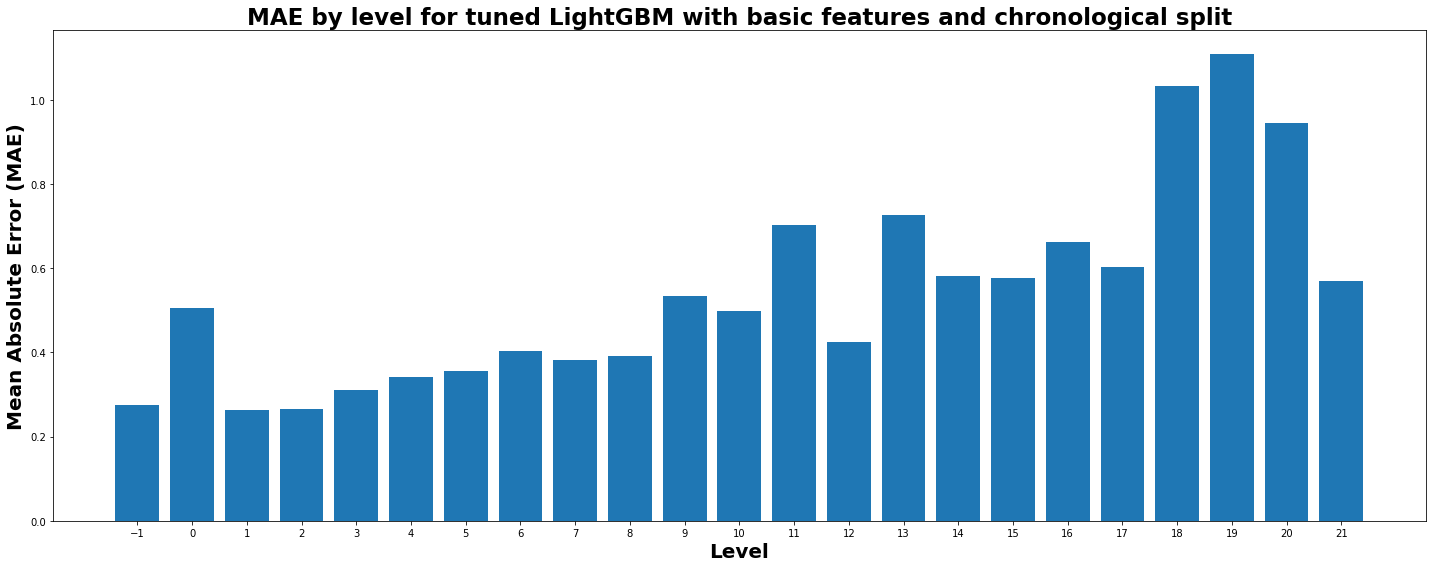

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.75

Round type: 0.5
RMSE: 0.78

Round type: 0.33
RMSE: 0.78

Round type: 0.45
RMSE: 0.77



In [29]:
predict[predict < -1] = -1
predict[predict > 21] = 21

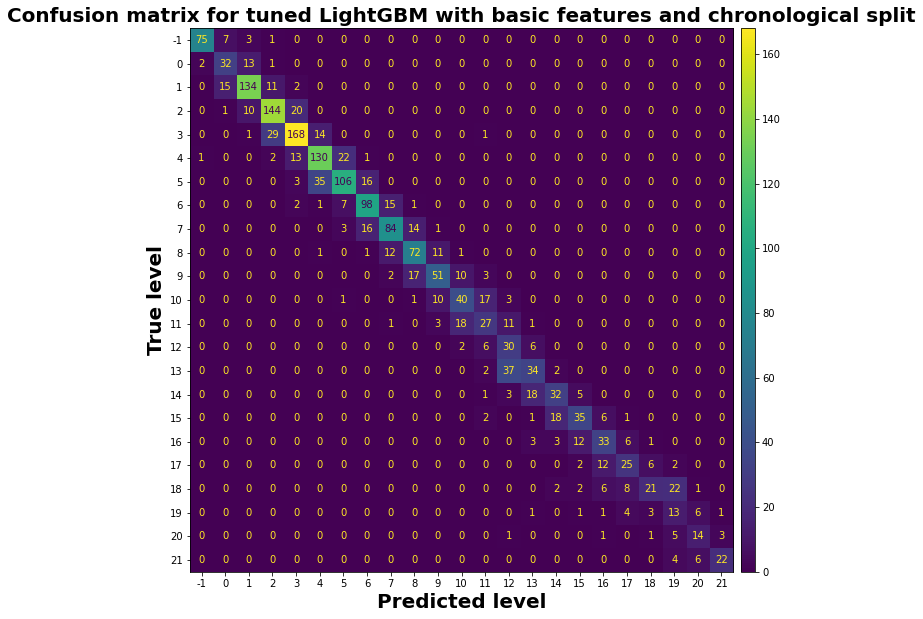

In [30]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and chronological split",
)

## Random split

In [31]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 2767, number of used features: 8
[LightGBM] [Info] Start training from score 7.220455
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 0.322742	valid_0's l1: 0.368391


In [32]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.57
MAE: 0.37


In [34]:
results.loc[2] = ["random", "default", "basic", rmse, mae]

###### MAE by level

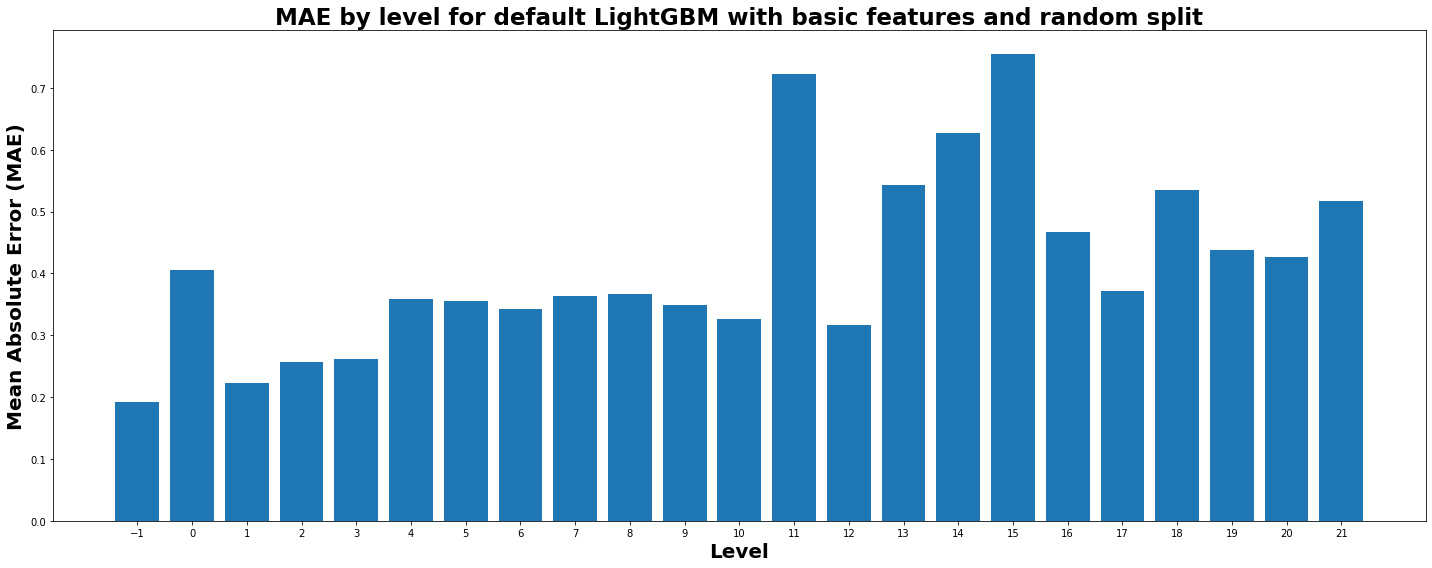

In [35]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with basic features and random split",
)

In [36]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.57

Round type: 0.5
RMSE: 0.60

Round type: 0.33
RMSE: 0.64

Round type: 0.45
RMSE: 0.60



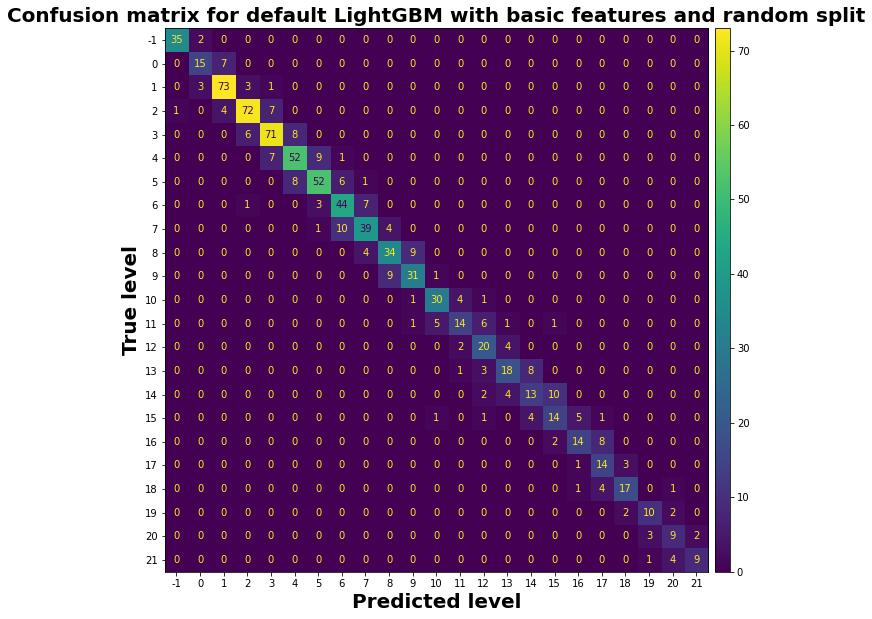

In [37]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with basic features and random split",
)

### Tuning

In [38]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-12-01 17:42:35,294] A new study created in memory with name: no-name-b2d7b78b-eded-4947-a25c-262752f202d3
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.38259 + 0.0979963
[200]	cv_agg's l2: 0.37809 + 0.0955408


feature_fraction, val_score: 0.377614:  14%|######4                                      | 1/7 [00:02<00:16,  2.80s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.377614 + 0.0962711
[100]	cv_agg's l2: 0.384684 + 0.0902822
[200]	cv_agg's l2: 0.37959 + 0.0897282


feature_fraction, val_score: 0.377614:  29%|############8                                | 2/7 [00:05<00:14,  2.89s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.377614 + 0.0962711
[100]	cv_agg's l2: 0.486775 + 0.0746439
[200]	cv_agg's l2: 0.436861 + 0.0817711


feature_fraction, val_score: 0.377614:  43%|###################2                         | 3/7 [00:08<00:10,  2.73s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.377614 + 0.0962711
[100]	cv_agg's l2: 0.426671 + 0.0807398
[200]	cv_agg's l2: 0.409928 + 0.0832138


feature_fraction, val_score: 0.377614:  57%|#########################7                   | 4/7 [00:10<00:07,  2.65s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.377614 + 0.0962711
[100]	cv_agg's l2: 0.394264 + 0.116915
[200]	cv_agg's l2: 0.393666 + 0.110216


feature_fraction, val_score: 0.377614:  71%|################################1            | 5/7 [00:13<00:05,  2.78s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.377614 + 0.0962711
[100]	cv_agg's l2: 0.390601 + 0.119172
[200]	cv_agg's l2: 0.387317 + 0.114032


feature_fraction, val_score: 0.377614:  86%|######################################5      | 6/7 [00:16<00:02,  2.74s/it]

Early stopping, best iteration is:
[186]	cv_agg's l2: 0.377614 + 0.0962711
[100]	cv_agg's l2: 0.38259 + 0.0979963
[200]	cv_agg's l2: 0.37809 + 0.0955408


feature_fraction, val_score: 0.377614: 100%|#############################################| 7/7 [00:19<00:00,  2.75s/it]


Early stopping, best iteration is:
[186]	cv_agg's l2: 0.377614 + 0.0962711


num_leaves, val_score: 0.377614:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.378081 + 0.096453


num_leaves, val_score: 0.377101:   5%|##5                                               | 1/20 [00:04<01:28,  4.64s/it]

[200]	cv_agg's l2: 0.381301 + 0.0953114
Early stopping, best iteration is:
[108]	cv_agg's l2: 0.377101 + 0.0949513
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


num_leaves, val_score: 0.373800:  10%|#####                                             | 2/20 [00:07<01:04,  3.59s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  15%|#######5                                          | 3/20 [00:16<01:39,  5.86s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.467026 + 0.111508
[200]	cv_agg's l2: 0.426856 + 0.10714


num_leaves, val_score: 0.373800:  20%|##########                                        | 4/20 [00:16<01:01,  3.87s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.385207 + 0.0907222
[200]	cv_agg's l2: 0.389968 + 0.0898523


num_leaves, val_score: 0.373800:  25%|############5                                     | 5/20 [00:23<01:12,  4.82s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  30%|###############                                   | 6/20 [00:33<01:33,  6.67s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  35%|#################5                                | 7/20 [00:41<01:31,  7.06s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  40%|####################                              | 8/20 [00:48<01:25,  7.14s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  45%|######################5                           | 9/20 [00:55<01:18,  7.15s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.467026 + 0.111508
[200]	cv_agg's l2: 0.426856 + 0.10714


num_leaves, val_score: 0.373800:  50%|########################5                        | 10/20 [00:56<00:51,  5.13s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  55%|##########################9                      | 11/20 [01:02<00:49,  5.49s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  60%|#############################4                   | 12/20 [01:09<00:46,  5.78s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.381226 + 0.0952773
[200]	cv_agg's l2: 0.381974 + 0.0936921


num_leaves, val_score: 0.373800:  65%|###############################8                 | 13/20 [01:14<00:39,  5.59s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  70%|##################################3              | 14/20 [01:20<00:35,  5.86s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.380632 + 0.0957294
[200]	cv_agg's l2: 0.383603 + 0.0937154


num_leaves, val_score: 0.373800:  75%|####################################7            | 15/20 [01:27<00:29,  5.98s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  80%|#######################################2         | 16/20 [01:34<00:24,  6.25s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  85%|#########################################6       | 17/20 [01:42<00:20,  6.98s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378081 + 0.096453
[200]	cv_agg's l2: 0.381301 + 0.0953114


num_leaves, val_score: 0.373800:  90%|############################################1    | 18/20 [01:49<00:14,  7.02s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.37719 + 0.0987531
[200]	cv_agg's l2: 0.376793 + 0.0973289


num_leaves, val_score: 0.373800:  95%|##############################################5  | 19/20 [01:53<00:05,  5.97s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.381736 + 0.100258
[200]	cv_agg's l2: 0.374284 + 0.0990483


num_leaves, val_score: 0.373800: 100%|#################################################| 20/20 [01:55<00:00,  5.79s/it]


Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537


bagging, val_score: 0.373800:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.406789 + 0.11028
[200]	cv_agg's l2: 0.401503 + 0.106861


bagging, val_score: 0.373800:  10%|#####3                                               | 1/10 [00:02<00:25,  2.89s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.381004 + 0.102134
[200]	cv_agg's l2: 0.380515 + 0.100729


bagging, val_score: 0.373800:  20%|##########6                                          | 2/10 [00:05<00:21,  2.68s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.392123 + 0.105109
[200]	cv_agg's l2: 0.388964 + 0.108994


bagging, val_score: 0.373800:  30%|###############9                                     | 3/10 [00:08<00:19,  2.74s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.409481 + 0.11414
[200]	cv_agg's l2: 0.402376 + 0.111142


bagging, val_score: 0.373800:  40%|#####################2                               | 4/10 [00:11<00:16,  2.76s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


bagging, val_score: 0.373800:  50%|##########################5                          | 5/10 [00:13<00:13,  2.78s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.380355 + 0.101181
[200]	cv_agg's l2: 0.377969 + 0.0987812


bagging, val_score: 0.373800:  60%|###############################8                     | 6/10 [00:16<00:11,  2.79s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.388368 + 0.0986828
[200]	cv_agg's l2: 0.383299 + 0.0993713


bagging, val_score: 0.373800:  70%|#####################################                | 7/10 [00:19<00:08,  2.82s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.39187 + 0.107089
[200]	cv_agg's l2: 0.383599 + 0.106891


bagging, val_score: 0.373800:  80%|##########################################4          | 8/10 [00:22<00:05,  2.83s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.394241 + 0.105954
[200]	cv_agg's l2: 0.394356 + 0.109837


bagging, val_score: 0.373800:  90%|###############################################7     | 9/10 [00:25<00:02,  2.85s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.391438 + 0.113194
[200]	cv_agg's l2: 0.384844 + 0.108628


bagging, val_score: 0.373800: 100%|####################################################| 10/10 [00:27<00:00,  2.79s/it]


Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537


feature_fraction_stage2, val_score: 0.373800:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


feature_fraction_stage2, val_score: 0.373800:  17%|######3                               | 1/6 [00:02<00:13,  2.66s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.390497 + 0.118444
[200]	cv_agg's l2: 0.390019 + 0.114159


feature_fraction_stage2, val_score: 0.373800:  33%|############6                         | 2/6 [00:05<00:11,  2.82s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.390497 + 0.118444
[200]	cv_agg's l2: 0.390019 + 0.114159


feature_fraction_stage2, val_score: 0.373800:  50%|###################                   | 3/6 [00:08<00:08,  2.79s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


feature_fraction_stage2, val_score: 0.373800:  67%|#########################3            | 4/6 [00:11<00:05,  2.91s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


feature_fraction_stage2, val_score: 0.373800:  83%|###############################6      | 5/6 [00:14<00:02,  2.91s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.390497 + 0.118444
[200]	cv_agg's l2: 0.390019 + 0.114159


feature_fraction_stage2, val_score: 0.373800: 100%|######################################| 6/6 [00:16<00:00,  2.79s/it]


Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537


regularization_factors, val_score: 0.373800:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.380286 + 0.10124
[200]	cv_agg's l2: 0.376686 + 0.0980302


regularization_factors, val_score: 0.373800:   5%|#9                                    | 1/20 [00:02<00:46,  2.46s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  10%|###8                                  | 2/20 [00:05<00:46,  2.56s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  15%|#####7                                | 3/20 [00:07<00:44,  2.63s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  20%|#######6                              | 4/20 [00:10<00:41,  2.60s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  25%|#########5                            | 5/20 [00:12<00:38,  2.55s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  30%|###########4                          | 6/20 [00:15<00:35,  2.52s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  35%|#############3                        | 7/20 [00:18<00:33,  2.60s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  40%|###############2                      | 8/20 [00:20<00:31,  2.61s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  45%|#################1                    | 9/20 [00:23<00:28,  2.55s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  50%|##################5                  | 10/20 [00:25<00:24,  2.50s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  55%|####################3                | 11/20 [00:28<00:22,  2.52s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  60%|######################2              | 12/20 [00:30<00:20,  2.56s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  65%|########################             | 13/20 [00:33<00:18,  2.59s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  70%|#########################9           | 14/20 [00:36<00:16,  2.68s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  75%|###########################7         | 15/20 [00:38<00:13,  2.67s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  80%|#############################6       | 16/20 [00:41<00:10,  2.71s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  85%|###############################4     | 17/20 [00:44<00:08,  2.68s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  90%|#################################3   | 18/20 [00:46<00:05,  2.63s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800:  95%|###################################1 | 19/20 [00:49<00:02,  2.57s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.378003 + 0.0961649
[200]	cv_agg's l2: 0.374177 + 0.0955219


regularization_factors, val_score: 0.373800: 100%|#####################################| 20/20 [00:51<00:00,  2.60s/it]


Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537


min_data_in_leaf, val_score: 0.373800:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.405048 + 0.114161
[200]	cv_agg's l2: 0.396226 + 0.112355


min_data_in_leaf, val_score: 0.373800:  20%|#########                                    | 1/5 [00:02<00:09,  2.44s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.462124 + 0.110304
[200]	cv_agg's l2: 0.448164 + 0.112157


min_data_in_leaf, val_score: 0.373800:  40%|##################                           | 2/5 [00:04<00:05,  1.95s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.379562 + 0.0998346
[200]	cv_agg's l2: 0.378789 + 0.106222


min_data_in_leaf, val_score: 0.373800:  60%|###########################                  | 3/5 [00:06<00:04,  2.38s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.387055 + 0.103184
[200]	cv_agg's l2: 0.384786 + 0.100499


min_data_in_leaf, val_score: 0.373800:  80%|####################################         | 4/5 [00:09<00:02,  2.45s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537
[100]	cv_agg's l2: 0.380895 + 0.0993412
[200]	cv_agg's l2: 0.376592 + 0.0994033


min_data_in_leaf, val_score: 0.373800: 100%|#############################################| 5/5 [00:11<00:00,  2.38s/it]

Early stopping, best iteration is:
[194]	cv_agg's l2: 0.3738 + 0.0955537


In [39]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.37380029146510113
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.825386053164414e-06
    lambda_l2: 1.0745184747530372e-06
    num_leaves: 27
    feature_fraction: 0.8
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


In [40]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [41]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.04
RMSE test: 0.57
MAE test: 0.37



In [42]:
results.loc[3] = ["random", "Optuna", "basic", rmse, mae]

###### MAE by level

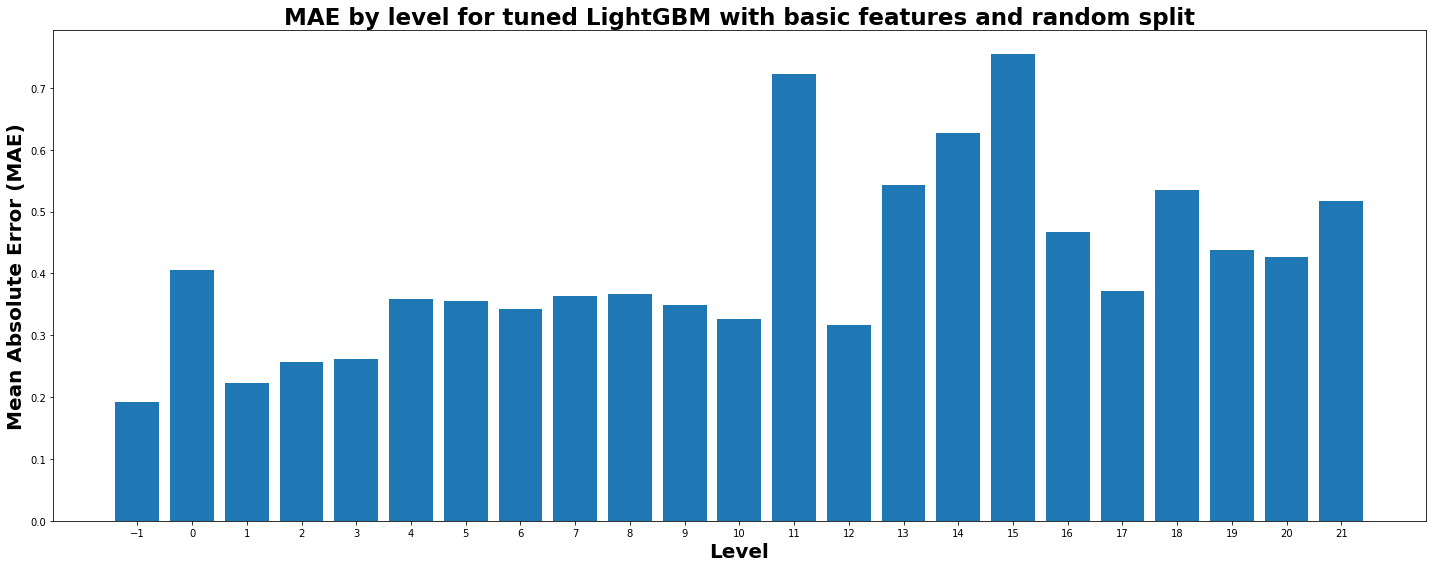

In [43]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with basic features and random split",
)

In [46]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.32

Round type: 0.5
RMSE: 0.34

Round type: 0.33
RMSE: 0.36

Round type: 0.45
RMSE: 0.35



In [47]:
predict[predict < -1] = -1
predict[predict > 21] = 21

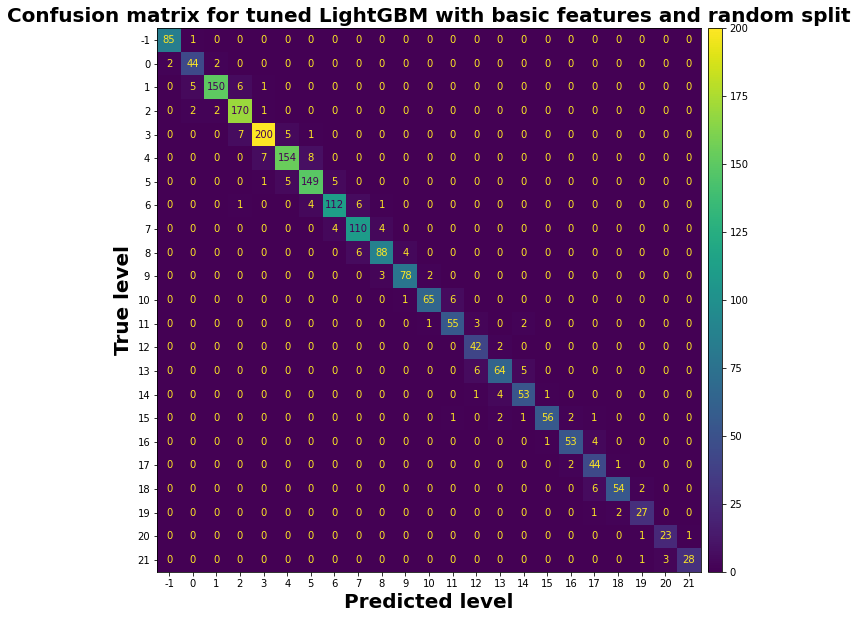

In [48]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with basic features and random split",
)

## Summary

In [49]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,basic,0.758623,0.447897
1,chronological,Optuna,basic,0.746421,0.451280
2,random,default,basic,0.568104,0.368391
3,random,Optuna,basic,0.573611,0.368044


In [50]:
from training.results import plot_summary

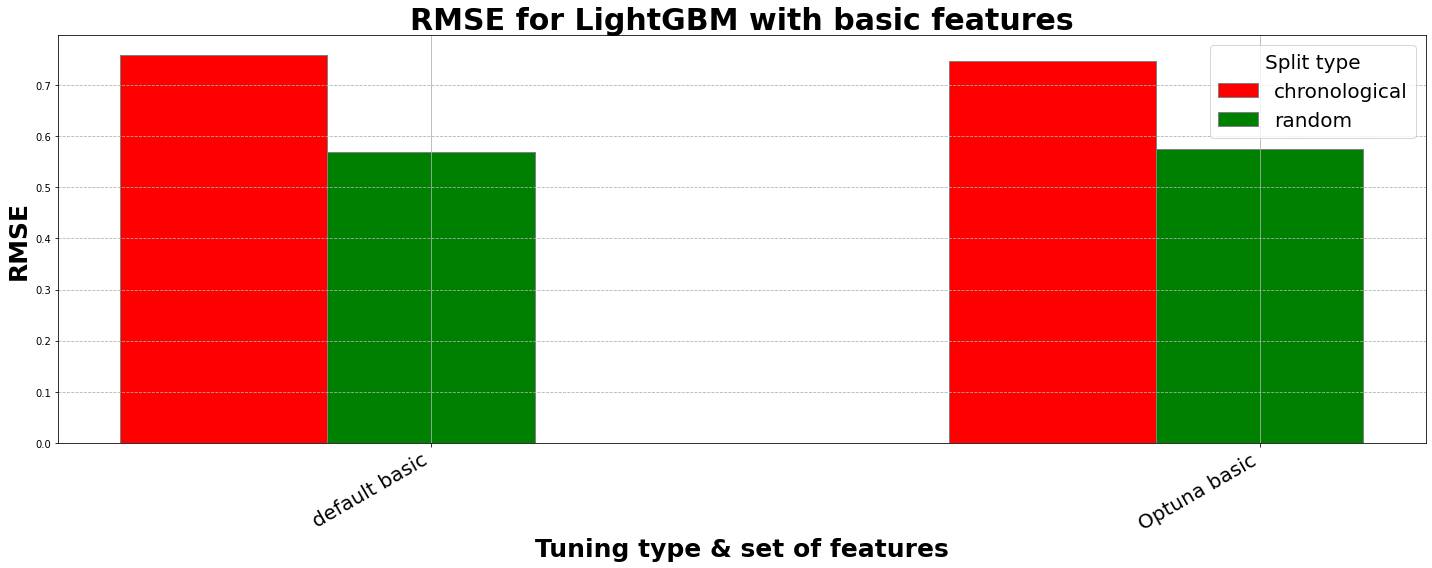

In [51]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with basic features")

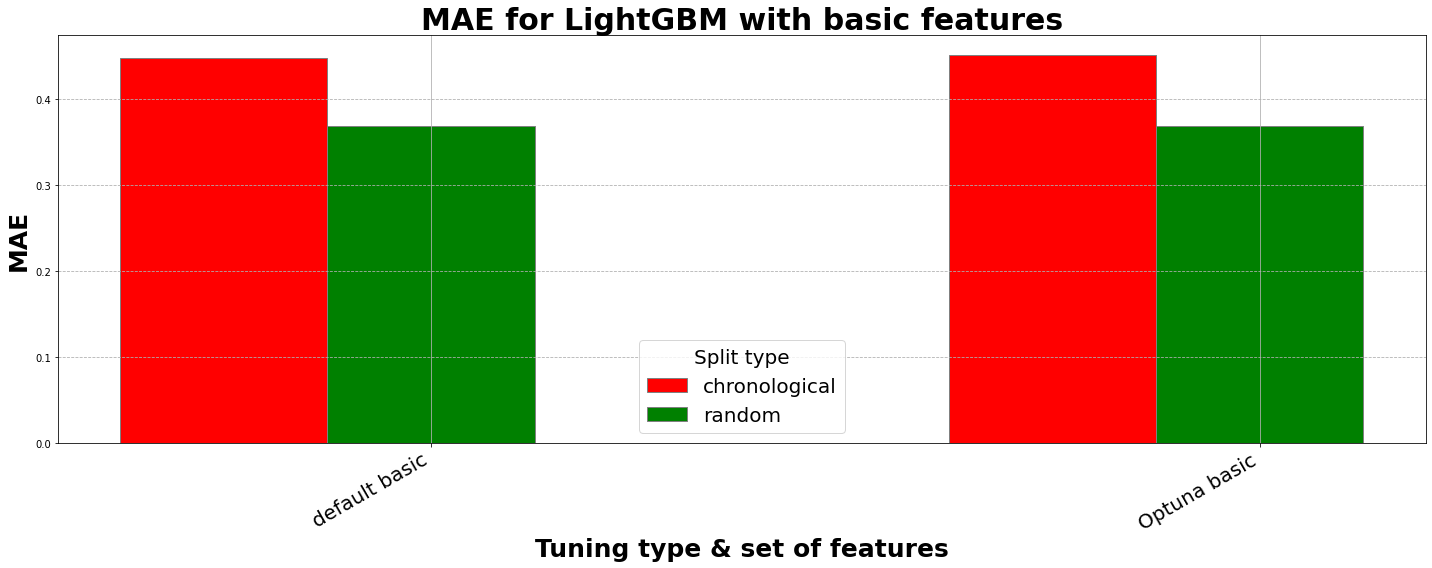

In [52]:
plot_summary(results, "MAE", title="MAE for LightGBM with basic features")

In [53]:
results.to_csv("./lightgbm_basic_results.csv")